=========================GridWorld Problem=================================

This code is to implement various algorithms on a gridworld MDP problem.
1. Constructing the gridworld environment.
2. Evaluating a policy using bellman equation and iterative policy evaluation to obtain the state value function.
3. finding the optimal state value functions and optimal policy for the environment using different algorithms

------------------------------------------------------------------------------

Problem Statement...........................................................

<img src="images/part1.PNG" width="800" height="800" />

# Necessary Libraries

In [1]:
import numpy as np                                                                    # package for scientific computing with arrays
import matplotlib.pyplot as plt                                                       # library for creating visualizations
import matplotlib as mpl                                                              # library for visualization
import seaborn as sns                                                                 # library for statistical data visualization
from scipy.optimize import fsolve                                                     # solves series of non-linear equations   
from matplotlib_inline.backend_inline import set_matplotlib_formats                   # library to display quality visualization
set_matplotlib_formats('svg', 'pdf')                                                  # plots as svg or pdf                                                       

# Gridworld MDP Environment

In [2]:
class GridworldMDP(object):

    # instantiate parameters of the enviroment
    def __init__(self):
        
        # gridsize = (row, col)
        self.gridsize = (5, 5)

        # all possible states
        self.state_space = [(row, col) for row in range(self.gridsize[0]) 
                            for col in range(self.gridsize[1])]
        
        # all possible actions
        self.action_space = ['up', 'down', 'left', 'right']

        # effect of action on row and column
        self.action_delta = {'up': (-1, 0),
                             'down': (1,0),
                             'left': (0, -1),
                             'right': (0, 1)
                             } 

        # special states       
        self.blue_state = (0, 1) 
        self.green_state = (0, 4) 
        self.red_state = (3, 2) 
        self.yellow_state = (4, 4) 

    
    # function to get (next state, probability, reward)
    def nextStateProbReward(self, state, action):

        # placeholder for (next state, transition probability, reward)
        result = [] 

        # obtain the possibility of transitioning to other states from the current one
        for s_prime in self.state_space:

            if state == self.blue_state:
                reward = 5 
                next_state = self.red_state
                if s_prime == next_state:
                    prob = 1 
                    result.append((s_prime, prob, reward))
                else:
                    prob = 0 
                    reward = 0
                    result.append((s_prime, prob, reward))                          

            elif state == self.green_state: 
                possible_next_state = [self.yellow_state, self.red_state] 
                if s_prime in possible_next_state: 
                    prob = 0.5
                    reward = 2.5
                    result.append((s_prime, prob, reward)) 
                else:
                    prob = 0  
                    reward = 0
                    result.append((s_prime, prob, reward))    
        
            else: 
                # effect of the action on the row and column                                                      
                delta = self.action_delta[action]
                next_state = (state[0]+delta[0], state[1]+delta[1]) 

                # check if next state is within the grid
                if 0 <= next_state[0] < self.gridsize[0] and 0 <= next_state[1] < self.gridsize[1]: 
                    if s_prime == next_state: 
                        prob = 1 
                        reward = 0
                        result.append((next_state, prob, reward))
                    else:
                        prob = 0 
                        reward = 0 
                        result.append((next_state, prob, reward))
                else:  
                    if s_prime == state:
                        prob = 1 
                        reward = -0.5
                        result.append((state, prob, reward))
                    else:
                        prob = 0     
                        reward = 0 
                        result.append((state, prob, reward))
        return result

# 1. Policy Evaluation

# Policy to be evaluated

In [3]:
def policy(action_space, state_space, probability =0.25): 

    # placeholder for action probability in each state
    prob_action_state = {} 
    for state in state_space:  
        for action in action_space: 
            prob_action_state[(state, action)] = probability 

    return prob_action_state 

# Bellman Equation using matrix formulation

By solving system of bellman equations explicitly using matrix formulation----------------------
Value function estimate of the states under equiprobable policy is --------------------------------
[[ 2.17100208  4.7336156   2.07028049  1.26529444  1.77912239]
 [ 1.1180732   1.7821227   1.17409573  0.739174    0.56246548]
 [ 0.16279444  0.47788999  0.35198379  0.11045592 -0.18617038]
 [-0.54699155 -0.28473257 -0.28040463 -0.43990985 -0.7443105 ]
 [-1.10787684 -0.84936779 -0.80799244 -0.93799278 -1.23723244]]


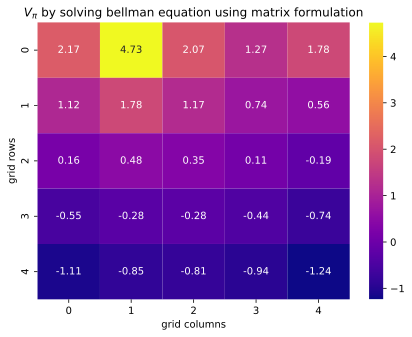

In [4]:
def solvingBellmanEquation(mdp, policy):
                                                                                        
    action_probs = policy(action_space= mdp.action_space,
                          state_space= mdp.state_space,
                          probability= 0.25)
    
    num_states = len(mdp.state_space)

    # define matrix P, R and I
    P = np.zeros((num_states, num_states))                                     
    gamma = 0.95 
    R = np.zeros(num_states) 
    I = np.eye(num_states)                                                                             

    # construct P and R matrices 
    for idx, state in enumerate(mdp.state_space):
        for action in mdp.action_space:
            for s_prime, p, r in mdp.nextStateProbReward(state, action): 
                next_state_idx = mdp.state_space.index(s_prime)
                P[idx, next_state_idx] += action_probs[(state, action)]*p    
                R[idx] += r * action_probs[(state, action)]*p 
    
    # solve for V
    V = np.linalg.inv(I - gamma * P).dot(R)

    return V.reshape(mdp.gridsize) 


# implement the solvingBellmanEquation function...............
mdp = GridworldMDP()
value_function = solvingBellmanEquation(mdp= mdp, policy= policy)

print('By solving system of bellman equations explicitly using matrix formulation----------------------')
print('Value function estimate of the states under equiprobable policy is --------------------------------')
print(value_function)

# visualize the value function
plt.figure(figsize=(7, 5))
cmap = mpl.colormaps['plasma']
sns.heatmap(value_function, annot=True, fmt=".2f", cmap= cmap, cbar=True)
plt.title('$V_{\pi}$ by solving bellman equation using matrix formulation')
plt.xlabel('grid columns')
plt.ylabel('grid rows')
plt.show()

# Bellman Equation using system of linear equations

By solving system of bellman equations explicitly using system of linear equations--------
Value function of the states under equiprobable policy is --------------------------------
[[ 2.17100208  4.7336156   2.07028049  1.26529444  1.77912239]
 [ 1.1180732   1.7821227   1.17409573  0.739174    0.56246548]
 [ 0.16279444  0.47788999  0.35198379  0.11045592 -0.18617038]
 [-0.54699155 -0.28473257 -0.28040463 -0.43990985 -0.7443105 ]
 [-1.10787684 -0.84936779 -0.80799244 -0.93799278 -1.23723244]]




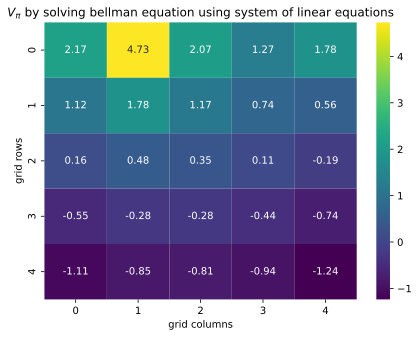

In [5]:
def bellman_equation(V): 

    # place holder for all value function equations in the form V = 0
    V_equations = [] 

    mdp = GridworldMDP()
    action_probs = policy(action_space= mdp.action_space,
                          state_space= mdp.state_space,
                          probability= 0.25)
    gamma = 0.95 
    
    # obtain the value functions
    for idx, state in enumerate(mdp.state_space):
        state_value = 0
        for action in mdp.action_space: 
            state_value += action_probs[(state, action)] * \
                sum(prob * (reward + gamma *V[mdp.state_space.index(next_state)]) \
                    for (next_state, prob, reward) in mdp.nextStateProbReward(state, action))
        V_equations.append(V[idx]- state_value) 

    return V_equations 

# solve the bellman equations.................
mdp = GridworldMDP()

# initial value for all V
initials = []
for state in mdp.state_space:                                                                      
    initials.append(-0.3) 


solutions = fsolve(func= bellman_equation,
                         x0= initials,
                         xtol= 1e-10)  

# obtain V from solutions
value_function = np.zeros(mdp.gridsize)
for idx, state in enumerate(mdp.state_space):
    value_function[state] = solutions[idx] 

# print the value functions 
print('By solving system of bellman equations explicitly using system of linear equations--------')
print('Value function of the states under equiprobable policy is --------------------------------')
print(value_function)
print('\n')

# visualize the value functions
plt.figure(figsize=(7, 5))
cmap = mpl.colormaps['viridis']
sns.heatmap(value_function, annot=True, fmt=".2f", cmap= cmap, cbar=True)
plt.title('$V_{\pi}$ by solving bellman equation using system of linear equations')
plt.xlabel('grid columns')
plt.ylabel('grid rows')
plt.show()

# Iterative Policy Evaluation

Using iterative policy evaluation-------------------------------------------------------
Value function estimate of the states under equiprobable policy is ---------------------
[[ 2.17100208  4.7336156   2.07028049  1.26529444  1.77912239]
 [ 1.1180732   1.7821227   1.17409573  0.739174    0.56246548]
 [ 0.16279445  0.47788999  0.35198379  0.11045592 -0.18617037]
 [-0.54699155 -0.28473257 -0.28040463 -0.43990985 -0.7443105 ]
 [-1.10787684 -0.84936779 -0.80799244 -0.93799278 -1.23723244]]




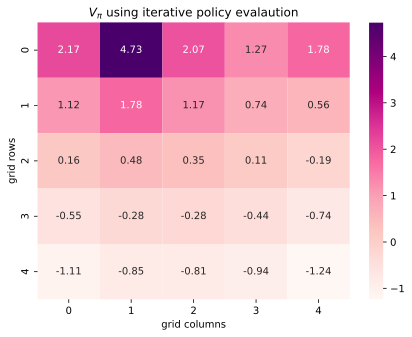

In [6]:
def iterativePolicyEvaluation(mdp): 

    action_probs = policy(action_space= mdp.action_space,
                          state_space= mdp.state_space,
                          probability= 0.25)
    
    # convergence threshold
    threshold = 1e-10   

    # convergence parameter
    delta = 1 

    # discount rate for future returns
    gamma = 0.95

    V = np.zeros(mdp.gridsize)

    # help function to obtain state-action value
    def Q(state, action): 
        return sum(prob * (reward + gamma * V[next_state]) \
                    for next_state, prob, reward in mdp.nextStateProbReward(state, action))

    while delta > threshold:
        delta = 0
        for state in mdp.state_space: 

            # old value function
            v = V[state]   

            # initialise new value function
            new_V = 0   
            for action in mdp.action_space:
                new_V += action_probs[(state, action)]* Q(state, action)
            
            # update the value function
            V[state] = new_V 
            delta = max(delta, abs(v - V[state])) 

    return V 

# implement iterative policy evaluation
mdp = GridworldMDP()
value_function = iterativePolicyEvaluation(mdp= mdp)

print('Using iterative policy evaluation-------------------------------------------------------')
print('Value function estimate of the states under equiprobable policy is ---------------------')
print(value_function)
print('\n')

# visualize the value function
plt.figure(figsize=(7, 5))
cmap = mpl.colormaps['RdPu']
sns.heatmap(value_function, annot=True, fmt=".2f", cmap= cmap, cbar=True)
plt.title('$V_{\pi}$ using iterative policy evalaution')
plt.xlabel('grid columns')
plt.ylabel('grid rows')
plt.show()

# 2. Optimal Policy 

# Bellman optimality equation

By solving system of bellman optimality equations explicitly as a system of nonlinear equations---------- ---
Optimal value function estimate of the states is -------------------------------------------------------------
[[20.9973 22.1025 20.9973 19.9475 18.3828]
 [19.9475 20.9973 19.9475 18.9501 18.0026]
 [18.9501 19.9475 18.9501 18.0026 17.1025]
 [18.0026 18.9501 18.0026 17.1025 16.2473]
 [17.1025 18.0026 17.1025 16.2473 15.435 ]]


Optimal policy is --------------------------------------------------------------------------------------------
[[list(['right']) list(['up', 'down', 'left', 'right']) list(['left'])
  list(['left']) list(['up', 'down', 'left', 'right'])]
 [list(['up', 'right']) list(['up']) list(['up', 'left'])
  list(['up', 'left']) list(['left'])]
 [list(['up', 'right']) list(['up']) list(['up', 'left'])
  list(['up', 'left']) list(['up', 'left'])]
 [list(['up', 'right']) list(['up']) list(['up', 'left'])
  list(['up', 'left']) list(['up', 'left'])]
 [list(['up', 'right

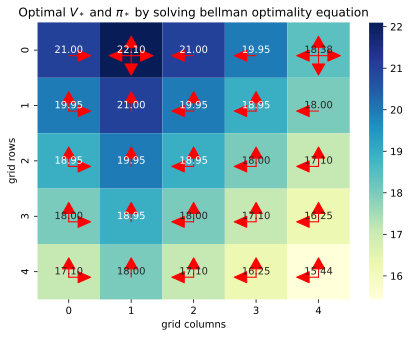

In [7]:
def bellmanOptimalityEquation(V): 

    # placeholder for all optimal value function equations                     
    V_optimal_equations = []

    mdp = GridworldMDP()                                                                                               
    gamma = 0.95 

    # obtain the system of nonlinear optimal value functions
    for idx, state in enumerate(mdp.state_space):
        state_action_values = []
        for action in mdp.action_space:
            action_value =  sum(prob * (reward + gamma *V[mdp.state_space.index(next_state)]) \
                               for (next_state, prob, reward) in mdp.nextStateProbReward(state, action))
            state_action_values.append(action_value)
        V_optimal_equations.append(V[idx]- max(state_action_values))

    return V_optimal_equations 


# solve the bellman equations for optimal value functions....................
mdp = GridworldMDP()

# initial value for all V
initials = [] 
for state in mdp.state_space: 
    initials.append(20)

solutions = fsolve(func= bellmanOptimalityEquation,
                         x0= initials,
                         xtol= 1e-10) 


# obtain optimal value functions from solutions.....................
optimal_value_function = np.zeros(mdp.gridsize)
for idx, state in enumerate(mdp.state_space):
    optimal_value_function[state] = round(solutions[idx],4)


# obtain the optimal policy (one step search)........................
# placeholder for the optimal policy
optimal_policy = np.zeros(mdp.gridsize, dtype= object)
for row in range(mdp.gridsize[0]):
    for col in range(mdp.gridsize[1]):
        optimal_policy[(row, col)] = [] 

gamma = 0.95 

for state in mdp.state_space:

    # placeholder for the action values of the states
    action_values = []
    for action in mdp.action_space:
        value = sum(prob * (reward + gamma * optimal_value_function[next_state]) \
                    for (next_state, prob, reward) in mdp.nextStateProbReward(state, action))
        action_values.append(value)
    max_value = max(action_values)

    # get all best actions to update the optimal policy
    best_action_idx = np.where(np.array(action_values) == max_value)[0]
    for idx in best_action_idx:
        optimal_policy[state].append(mdp.action_space[idx])


print('By solving system of bellman optimality equations explicitly as a system of nonlinear equations---------- ---')
print('Optimal value function estimate of the states is -------------------------------------------------------------')
print(optimal_value_function)
print('\n')
print('Optimal policy is --------------------------------------------------------------------------------------------')
print(optimal_policy)
print('\n')

# visualize the optimal value function and optimal policy............
action_to_arrow = {
    'up': (0, 0.5),
    'down': (0, -0.5),
    'left': (-0.5, 0),
    'right': (0.5, 0)
}

plt.figure(figsize=(7, 5))
sns.heatmap(optimal_value_function, annot=True, fmt=".2f", cmap= "YlGnBu", cbar=True)
plt.title('Optimal $V_*$ and $\pi_*$ by solving bellman optimality equation')
plt.xlabel('grid columns')
plt.ylabel('grid rows')

for y in range(mdp.gridsize[0]):
    for x in range(mdp.gridsize[1]):
        actions = optimal_policy[y, x]
        for action in actions:
            dx, dy = action_to_arrow[action]
            plt.arrow(x + 0.5, y + 0.6, dx*0.3, -dy*0.3, head_width=0.2, head_length=0.2, fc='red', ec='red')
plt.show()

# Policy Iteration

By using policy iteration with iterative policy evaluation----------------------------
Optimal value function estimate of the states is -------------------------------------
[[20.99734632 22.10246981 20.99734632 19.94747901 18.38284993]
 [19.94747901 20.99734632 19.94747901 18.95010506 18.0025998 ]
 [18.95010506 19.94747901 18.95010506 18.0025998  17.10246981]
 [18.0025998  18.95010506 18.0025998  17.10246981 16.24734632]
 [17.10246981 18.0025998  17.10246981 16.24734632 15.43497901]]


Optimal policy is --------------------------------------------------------------------
[[list(['right']) list(['up', 'down', 'left', 'right']) list(['left'])
  list(['left']) list(['up', 'down', 'left', 'right'])]
 [list(['up', 'right']) list(['up']) list(['up', 'left'])
  list(['up', 'left']) list(['left'])]
 [list(['up', 'right']) list(['up']) list(['up', 'left'])
  list(['up', 'left']) list(['up', 'left'])]
 [list(['up', 'right']) list(['up']) list(['up', 'left'])
  list(['up', 'left']) list(['up', '

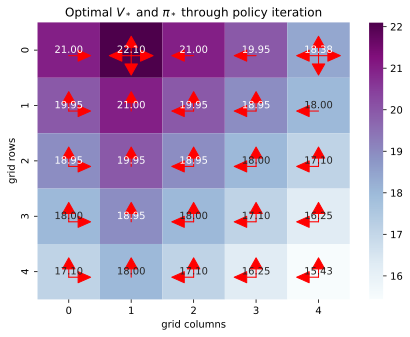

In [8]:
def policyEvaluation(mdp, policy): 

    threshold = 1e-10 

    # initialization
    gamma = 0.95
    delta = 1 
    V = np.zeros(mdp.gridsize)
    
    while delta > threshold:
        delta = 0

        # helping function to get stat-action value
        def Q(state, action):
            return sum(prob * (reward + gamma * V[next_state]) \
                    for (next_state, prob, reward) in mdp.nextStateProbReward(state, action))
        
        for state in mdp.state_space: 
            # old value function
            v = V[state] 

            # select action from the random policy
            action = policy[state][0] 

            # update the value function  
            new_V = Q(state, action)                                                             
            V[state] = new_V 

            # update convergence parameter
            delta = max(delta, abs(v - V[state])) 
    
    return V 


def policyImprovement(V):
    policy_stable = True

    for state in mdp.state_space:
        old_action = policy[state][0]
        action_values = []
        for action in mdp.action_space:
            value = sum(prob * (reward + gamma * V[next_state]) \
                    for (next_state, prob, reward) in mdp.nextStateProbReward(state, action))
            action_values.append(round(value, 2))
        
        max_value = max(action_values)

        # get all best actions from the state-action value
        best_action_idx = np.where(np.array(action_values) == max_value)[0] 

        best_action = []  
        for idx in best_action_idx:
            best_action.append(mdp.action_space[idx]) 
        
        # update policy
        policy[state] = best_action 
        if old_action not in best_action:
            policy_stable = False
    
    return policy, policy_stable


def policyIteration(mdp, policy):
    while True:                                                                                     
        V = policyEvaluation(mdp, policy) 
        policy, policy_stable = policyImprovement(V)
        if policy_stable:                                                                          
            break
    return V, policy 
            
# implement policy iteration............................
mdp = GridworldMDP() 

# choose a policy as a random action
random_action = np.random.choice(np.array(mdp.action_space))
policy = np.zeros(mdp.gridsize, dtype= object) 
for (row, col) in mdp.state_space:                                             
    policy[(row, col)] = []  
for state in mdp.state_space:
    policy[state].append(random_action) 


optimal_value_function, optimal_policy = policyIteration(mdp= mdp, policy= policy)

print('By using policy iteration with iterative policy evaluation----------------------------')
print('Optimal value function estimate of the states is -------------------------------------')
print(optimal_value_function)
print('\n')
print('Optimal policy is --------------------------------------------------------------------')
print(optimal_policy)
print('\n')

# visualize the optimal value function and optimal policy.....................................
action_to_arrow = {
    'up': (0, 0.5),
    'down': (0, -0.5),
    'left': (-0.5, 0),
    'right': (0.5, 0)
}

plt.figure(figsize=(7, 5))
sns.heatmap(optimal_value_function, annot=True, fmt=".2f", cmap= 'BuPu', cbar=True)
plt.title('Optimal $V_*$ and $\pi_*$ through policy iteration')
plt.xlabel('grid columns')
plt.ylabel('grid rows')

for y in range(mdp.gridsize[0]):
    for x in range(mdp.gridsize[1]):
        actions = optimal_policy[y, x]
        for action in actions:
            dx, dy = action_to_arrow[action]
            plt.arrow(x + 0.5, y + 0.6, dx*0.3, -dy*0.3, head_width=0.2, head_length=0.2, fc='red', ec='red')
            
plt.show()

# Value Iteration

Using Value Iteration-------------------------------------------------
Optimal value function estimate of the states is --------------------
[[20.99734632 22.10246981 20.99734632 19.94747901 18.38284993]
 [19.94747901 20.99734632 19.94747901 18.95010506 18.0025998 ]
 [18.95010506 19.94747901 18.95010506 18.0025998  17.10246981]
 [18.0025998  18.95010506 18.0025998  17.10246981 16.24734632]
 [17.10246981 18.0025998  17.10246981 16.24734632 15.43497901]]


Optimal policy is ---------------------------------------------------
[[list(['right']) list(['up', 'down', 'left', 'right']) list(['left'])
  list(['left']) list(['up', 'down', 'left', 'right'])]
 [list(['up', 'right']) list(['up']) list(['up', 'left'])
  list(['up', 'left']) list(['left'])]
 [list(['up', 'right']) list(['up']) list(['up', 'left'])
  list(['up', 'left']) list(['up', 'left'])]
 [list(['up', 'right']) list(['up']) list(['up', 'left'])
  list(['up', 'left']) list(['up', 'left'])]
 [list(['up', 'right']) list(['up']) list

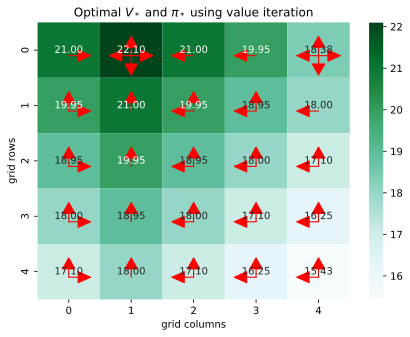

In [9]:
def valueIteration(mdp):

    # parameters
    threshold = 1e-10   
    gamma = 0.95 

    # intialization
    delta = 1 
    V = np.zeros(mdp.gridsize)
    
    while delta > threshold: 
        delta = 0

        # helping function to get state-action value
        def Q(state, action): 
            return sum(prob * (reward + gamma * V[next_state]) \
                    for (next_state, prob, reward) in mdp.nextStateProbReward(state, action)) 

        for state in mdp.state_space: 
            # old value function
            v = V[state] 
            action_values = [] 
            for action in mdp.action_space: 
                value = Q(state, action)  
                action_values.append(value)  

            # new value function                                                      
            V[state] = max(action_values)

            # update convergence parameter
            delta = max(delta, abs(v - V[state]))
    
    return V 

# implement value iteration .....................................
mdp = GridworldMDP()
optimal_value_function = valueIteration(mdp= mdp)

# obtain the optimal policy through improvement...................
optimal_policy = np.zeros(mdp.gridsize, dtype= object)
for row in range(mdp.gridsize[0]):
    for col in range(mdp.gridsize[1]):
        optimal_policy[(row, col)] = [] 

gamma = 0.95 

# one step search for optimal policy
for state in mdp.state_space:
    action_values = []
    for action in mdp.action_space:
        value = sum(prob * (reward + gamma * optimal_value_function[next_state]) \
                    for (next_state, prob, reward) in mdp.nextStateProbReward(state, action))
        action_values.append(round(value, 2))
    max_value = max(action_values) 
    
    # all best actions to update the optimal policy
    best_action_idx = np.where(np.array(action_values) == max_value)[0]
    for idx in best_action_idx:
        optimal_policy[state].append(mdp.action_space[idx])


print('Using Value Iteration-------------------------------------------------')
print('Optimal value function estimate of the states is --------------------')
print(optimal_value_function)
print('\n')
print('Optimal policy is ---------------------------------------------------')
print(optimal_policy)

# visualize the optimal value function and optimal policy...................
action_to_arrow = {
    'up': (0, 0.5),
    'down': (0, -0.5),
    'left': (-0.5, 0),
    'right': (0.5, 0)
}

plt.figure(figsize=(7, 5))
sns.heatmap(optimal_value_function, annot=True, fmt=".2f", cmap= 'BuGn', cbar=True)
plt.title('Optimal $V_*$ and $\pi_*$ using value iteration')
plt.xlabel('grid columns')
plt.ylabel('grid rows')

for y in range(mdp.gridsize[0]):
    for x in range(mdp.gridsize[1]):
        actions = optimal_policy[y, x]
        for action in actions:
            dx, dy = action_to_arrow[action]
            plt.arrow(x + 0.5, y + 0.6, dx*0.3, -dy*0.3, head_width=0.2, head_length=0.2, fc='red', ec = 'red')
            
plt.show() 